In [44]:
import numpy as np
from PIL import Image
from typing import Tuple

def rgb2gray(image_array: np.ndarray) -> np.ndarray:
    """
    Convert an RGB image (as a NumPy array) to grayscale.
    
    Parameters:
        image_array: A NumPy array representing an RGB image.
        
    Returns:
        A 2D NumPy array representing the grayscale image.
    """
    return np.dot(image_array[..., :3], [0.2989, 0.5870, 0.1140])

def sobel_gradients(gray_image: np.ndarray) -> np.ndarray:
    """
    Compute the gradient magnitude using the Sobel operator.
    
    Parameters:
        gray_image: A 2D NumPy array representing the grayscale image.
        
    Returns:
        A 2D NumPy array of the gradient magnitude.
    """
    # Define Sobel kernels.
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=np.float32)
    Ky = np.array([[-1, -2, -1],
                   [ 0,  0,  0],
                   [ 1,  2,  1]], dtype=np.float32)
    
    H, W = gray_image.shape
    padded = np.pad(gray_image, ((1, 1), (1, 1)), mode='edge')
    Gx = np.empty((H, W), dtype=np.float32)
    Gy = np.empty((H, W), dtype=np.float32)
    
    for i in range(H):
        for j in range(W):
            patch = padded[i:i+3, j:j+3]
            Gx[i, j] = np.sum(Kx * patch)
            Gy[i, j] = np.sum(Ky * patch)
    
    grad_magnitude = np.sqrt(Gx**2 + Gy**2)
    return grad_magnitude

def compute_edge_confidence(pil_image: Image.Image, edge_threshold: int = 50, window_size: int = 20) -> Tuple[float, np.ndarray]:
    """
    Compute an edge-based confidence score indicating the likelihood of an animal presence.
    
    Parameters:
        pil_image: A PIL Image object.
        edge_threshold: Threshold on gradient magnitude to detect edges.
        window_size: Size of the sliding window to capture local edge blobs.
    
    Returns:
        A tuple containing:
          - confidence: A float value between 0 and 1.
          - edge_map: A binary NumPy array representing the detected edges.
    """
    # Convert image to grayscale array.
    gray_array = np.array(pil_image.convert('L'), dtype=np.float32)
    grad_mag = sobel_gradients(gray_array)
    
    # Create binary edge map.
    edge_map = (grad_mag > edge_threshold).astype(np.uint8)
    edge_fraction = np.sum(edge_map) / edge_map.size

    # Determine maximum edge blob within sliding windows.
    H, W = edge_map.shape
    max_blob = 0
    for i in range(0, H - window_size + 1, window_size):
        for j in range(0, W - window_size + 1, window_size):
            window = edge_map[i:i+window_size, j:j+window_size]
            max_blob = max(max_blob, np.sum(window))
    blob_fraction = max_blob / (window_size * window_size)
    
    # Combine metrics into a single confidence score.
    confidence = (edge_fraction + blob_fraction) / 2.0
    return confidence, edge_map

In [45]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
from typing import Optional

def downsample_image(img: Image.Image, scale_factor: float = 0.5) -> Image.Image:
    """
    Downsamples (resizes) the given image by the provided scale factor.

    Parameters:
        img (Image.Image): The Pillow Image to downsample.
        scale_factor (float): The factor by which to scale the image (e.g., 0.5 for half-size).

    Returns:
        Image.Image: The resized image.
    """
    width, height = img.size
    return img.resize((int(width * scale_factor), int(height * scale_factor)))

def measure_changes(past: Optional[Image.Image], 
                    present: Optional[Image.Image], 
                    future: Optional[Image.Image], 
                    scale_factor: float = 0.5) -> float:
    """
    Measures pixel changes between three images using the Structural Similarity Index (SSIM).

    The function downscales each image, converts them to grayscale, computes SSIM between the
    past and present images as well as between the present and future images, then returns the 
    average difference (1 - average SSIM).

    If any image is missing (None), the function returns 0.

    Parameters:
        past (Optional[Image.Image]): The past image.
        present (Optional[Image.Image]): The current image.
        future (Optional[Image.Image]): The future image.
        scale_factor (float): The factor by which to downsample the images.

    Returns:
        float: The difference measure derived from SSIM (0 indicates perfect similarity).
    """
    if past is None or present is None or future is None:
        return 0.0

    past_ds = downsample_image(past, scale_factor)
    present_ds = downsample_image(present, scale_factor)
    future_ds = downsample_image(future, scale_factor)

    past_array = np.array(past_ds.convert("L"), dtype=np.float32)
    present_array = np.array(present_ds.convert("L"), dtype=np.float32)
    future_array = np.array(future_ds.convert("L"), dtype=np.float32)

    ssim_prev_curr = ssim(past_array, present_array, data_range=255)
    ssim_curr_next = ssim(present_array, future_array, data_range=255)
    avg_ssim = (ssim_prev_curr + ssim_curr_next) / 2

    return 1 - avg_ssim


# Dynamic Threshold Computation for CritterSnap Image Analysis


In [46]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from random import sample
from statistics import mean

In [ ]:
# Load configuration
CONFIG_PATH = "config.json"

try:
    with open(CONFIG_PATH, 'r') as f:
        config = json.load(f)
except FileNotFoundError:
    print("Configuration file not found. Using default values.")
    config = {
        "edge_threshold": 50,
        "window_size": 20,
        "change_threshold": 0.1,
        "edge_confidence_threshold": 0.15,
        "animal_training_path": r"C:\Users\rf4thyrvm\Documents\CritterSnap\data\example\as_conservationistFrankfurt\IE_Forest_County_Wicklow_21_loc_01-20241031T145429Z-001\IE_Forest_County_Wicklow_21_loc_11"
    }


In [48]:
# Load training images
training_path = config["animal_training_path"]
if not os.path.isdir(training_path):
    raise FileNotFoundError("Invalid training path: " + training_path)

files = [os.path.join(training_path, f) for f in os.listdir(training_path) if os.path.isfile(os.path.join(training_path, f))]
if len(files) < 3:
    raise ValueError(f"Only {len(files)} images in training directory for threshold computation.")



In [49]:
# Sample images for threshold computation
sample_size = min(20, len(files))  # Limit to 10 samples for efficiency
sample_files = sorted(sample(files, sample_size))

In [50]:
edge_confidences = []
for file in sample_files:
    with Image.open(file) as img:
        edge_conf, _ = compute_edge_confidence(img, config["edge_threshold"], config["window_size"])
        edge_confidences.append(edge_conf)

In [51]:
change_measures = []
images = [Image.open(f) for f in sample_files]
for i in range(1, len(images) - 1):
    change = measure_changes(images[i - 1], images[i], images[i + 1])
    change_measures.append(change)

In [52]:
print(f"Edge confidences: {edge_confidences}")
print(f"Change measures: {change_measures}")
# Compute new thresholds
new_edge_conf_threshold = mean(edge_confidences)
new_change_threshold = mean(change_measures)

# Update and display thresholds
config["edge_confidence_threshold"] = new_edge_conf_threshold
config["change_threshold"] = new_change_threshold

print(f"New edge confidence threshold: {new_edge_conf_threshold:.3f}")
print(f"New change threshold: {new_change_threshold:.3f}")

Edge confidences: [np.float64(0.9115219907407408), np.float64(0.8746460262345679), np.float64(0.7022391010802469), np.float64(0.7824269386574074), np.float64(0.7838175154320988), np.float64(0.9099370659722222), np.float64(0.69310546875), np.float64(0.6949329668209876), np.float64(0.8798037229938271), np.float64(0.8690996334876543), np.float64(0.708923369984568), np.float64(0.6912526523919753), np.float64(0.6700467785493828), np.float64(0.6735747010030865), np.float64(0.843631606867284), np.float64(0.7613189621913581), np.float64(0.6933849344135803), np.float64(0.6901593846450618), np.float64(0.6919109278549382), np.float64(0.6817660108024691)]
Change measures: [np.float64(0.736569294356688), np.float64(0.9014624831356676), np.float64(0.4809556729203207), np.float64(0.35153208854618234), np.float64(0.7748822107884306), np.float64(0.6558663770771405), np.float64(0.6650010409558774), np.float64(0.5614083451856806), np.float64(0.556053801950616), np.float64(0.7149953302374845), np.float64(

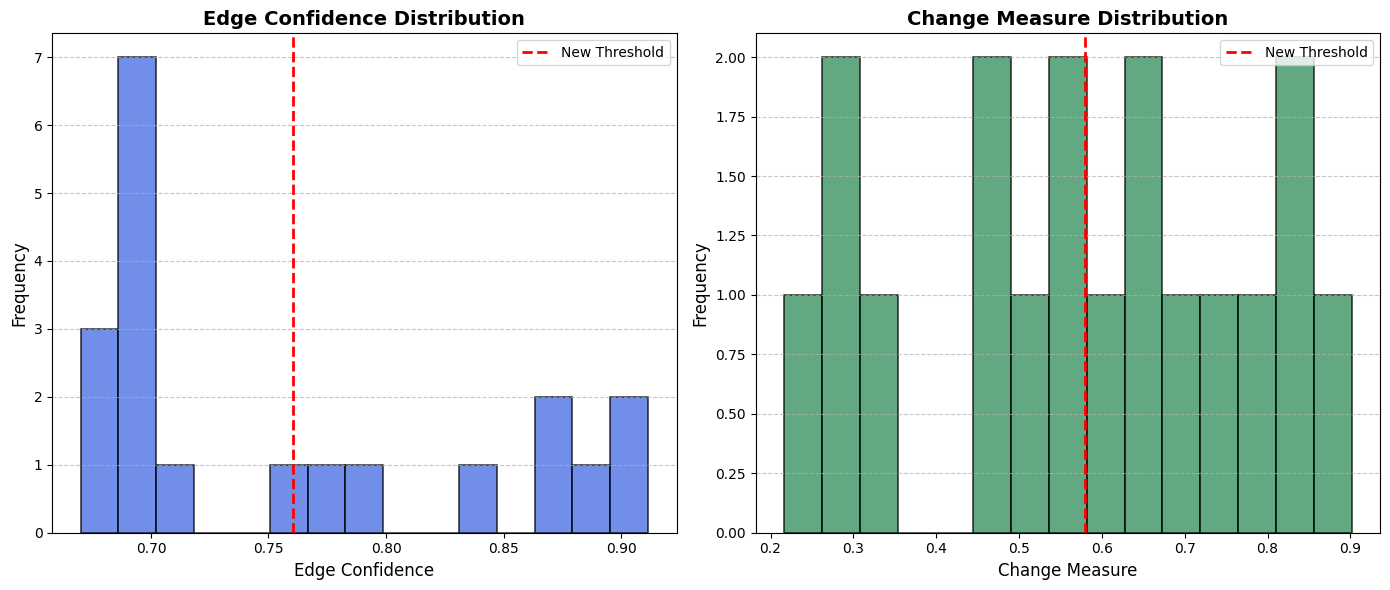

In [53]:
import matplotlib.pyplot as plt

# Create improved plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Edge Confidence Distribution
axes[0].hist(edge_confidences, bins=15, alpha=0.75, color='royalblue', edgecolor='black', linewidth=1.2)
axes[0].axvline(new_edge_conf_threshold, color='red', linestyle='dashed', linewidth=2, label='New Threshold')
axes[0].set_title("Edge Confidence Distribution", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Edge Confidence", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Change Measure Distribution
axes[1].hist(change_measures, bins=15, alpha=0.75, color='seagreen', edgecolor='black', linewidth=1.2)
axes[1].axvline(new_change_threshold, color='red', linestyle='dashed', linewidth=2, label='New Threshold')
axes[1].set_title("Change Measure Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Change Measure", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()